In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch

from junctionart.roundabout.sacDiscrete.Discrete_SAC_Agent import SACAgent
from junctionart.roundabout.encodingGFN.setGenerationEnv import SetGenerationEnv

 Run: 2/2 | Episode: 1500/1500 Run: 1/2 | Episode: 1311/1500 Run: 2/2 | Episode: 1011/1500 Run: 2/2 | Episode: 1045/1500 Run: 2/2 | Episode: 1405/1500 

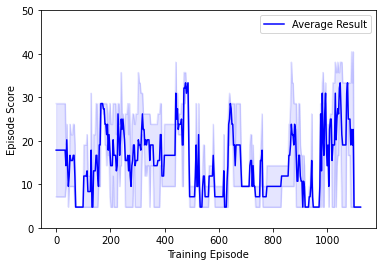

In [8]:
TRAINING_EVALUATION_RATIO = 4
RUNS = 2
EPISODES_PER_RUN = 1500
STEPS_PER_EPISODE = 200

# roadDefinition = [
#             {"x": 80, "y": 20, "heading": math.radians(30),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
#             {"x": 210, "y": 20, "heading": math.radians(145),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
# ]
roadDefinition = roadDefs[0]

size = 6
nActions = 30

env = SetGenerationEnv(size, nActions, roadDefinition, base = 10**9)
agent_results = []
for run in range(RUNS):
    agent = SACAgent(env)
    run_results = []
    for episode_number in range(EPISODES_PER_RUN):
        print('\r', f'Run: {run + 1}/{RUNS} | Episode: {episode_number + 1}/{EPISODES_PER_RUN}', end=' ')
        evaluation_episode = episode_number % TRAINING_EVALUATION_RATIO == 0
        episode_reward = 0
        s = torch.zeros(1, size)
        done = False
        i = 0
        while not done and i < STEPS_PER_EPISODE:
            i += 1

            action = agent.get_next_action((s/nActions).squeeze().tolist(), evaluation_episode=evaluation_episode)
            # next_state, reward, terminated, truncated , info = env.step(action)
            # done = terminated or truncated
        
            next_state = env.update(s, torch.tensor([action]), inPlace=False)

            done = (next_state != 0).all().item()
            
            if done:
                config = (next_state.squeeze() - 1).long().tolist()
                reward = 50*env.getProxyReward(config, normalize=True)
         
            else:
                reward = 0
            if not evaluation_episode:
                agent.train_on_transition((s/nActions).squeeze().tolist(), action, (next_state/nActions).squeeze().tolist(), reward, done)
            else:
                episode_reward += reward
            s = next_state
        if evaluation_episode:
            run_results.append(episode_reward)
    
    agent_results.append(run_results)


n_results = EPISODES_PER_RUN // TRAINING_EVALUATION_RATIO
results_mean = [np.mean([agent_result[n] for agent_result in agent_results]) for n in range(n_results)]
results_std = [np.std([agent_result[n] for agent_result in agent_results]) for n in range(n_results)]
mean_plus_std = [m + s for m, s in zip(results_mean, results_std)]
mean_minus_std = [m - s for m, s in zip(results_mean, results_std)]

x_vals = list(range(len(results_mean)))
x_vals = [x_val * (TRAINING_EVALUATION_RATIO - 1) for x_val in x_vals]

ax = plt.gca()
ax.set_ylim([0, 50])
ax.set_ylabel('Episode Score')
ax.set_xlabel('Training Episode')
ax.plot(x_vals, results_mean, label='Average Result', color='blue')
ax.plot(x_vals, mean_plus_std, color='blue', alpha=0.1)
ax.plot(x_vals, mean_minus_std, color='blue', alpha=0.1)
ax.fill_between(x_vals, y1=mean_minus_std, y2=mean_plus_std, alpha=0.1, color='blue')
plt.legend(loc='best')
plt.show()


In [35]:
def train(env, nIter, batchSize, base = 100):
    agent = SACAgent(env, batch_size=batchSize)
    run_results = []
    for episode_number in range(nIter):
        episode_reward = 0
        s = torch.zeros(1, size)
        done = False
     
        while not done:
            action = agent.get_next_action((s/nActions).squeeze().tolist(), evaluation_episode=False)
      
            next_state = env.update(s, torch.tensor([action]), inPlace=False)

            done = (next_state != 0).all().item()

            if done:
                config = (next_state.squeeze() - 1).long().tolist()
                reward = base**env.getProxyReward(config, normalize=True)
            else:
                reward = 0
            
            agent.train_on_transition((s/nActions).squeeze().tolist(), action, (next_state/nActions).squeeze().tolist(), reward, done)
            
            s = next_state
        print('\r', f'Episode: {episode_number + 1}/{nIter} | reward: {reward}', end=' ')
        
    return agent

def sample(agent, num):
    samples = []
    
        
    s = torch.zeros(num, size)
    done = False
    episode_reward = torch.zeros(num)
    while not done:
        actions = agent.get_actions_in_batches(s/nActions)
        next_state = env.update(s, actions, inPlace=False)

        done = (next_state != 0).all().item()

        if done:
            config = (next_state.squeeze() - 1).long().tolist()
            for i in tqdm(range(len(config))):
               
                episode_reward[i] += env.getProxyReward(config[i], normalize=True)


        s = next_state
    s = s - 1
    for i in range(num):
        samples.append((s[i].long().tolist(), episode_reward[i].item()))
    return samples

def getNumberOfStates(samples):
    sampleCnt = {}
    for sample, reward in samples:
        if str(sample) in sampleCnt:
            cnt, r = sampleCnt[str(sample)]
            sampleCnt[str(sample)] = (cnt + 1, r)
        else:
            sampleCnt[str(sample)] = (1, reward)
    return sampleCnt

In [34]:
# env = SetGenerationEnv(size, nActions, roadDefinition, base = 10**9)
# agent = train(env, 1000, 128, 100)
samples = sample(agent, 10**5)
stateDir = getNumberOfStates(samples)
# modes, proxyRewards = getTopK(samples, 200)
# roundabouts = getRoundabouts(roadDefinition, modes)
# rewards = getRewards(roundabouts)
# print(rewards[:50].mean())
print(len(stateDir))

99897


In [37]:
from tqdm import tqdm
import numpy as np
from junctionart.roundabout.encodingGFN.RoundaboutLaneEncodingEnv import RoundaboutLaneEncodingEnv
from junctionart.roundabout.RewardUtil import RewardUtil

def getTopK(rewardWithConfigs, K):
    modes = []
    proxyRewards = []
    
    rewardWithConfigs.sort(key = lambda x : x[1], reverse=True)

    for config, reward in rewardWithConfigs[:K]: # top-500 samples
        modes.append(config)
        proxyRewards.append(reward)

    
    return modes, proxyRewards

def getRoundabouts(roadDefinition, modes):
    env = RoundaboutLaneEncodingEnv()
    roundabouts = []
    for i in tqdm(range(len(modes))):
        env.generateWithRoadDefinition(
            roadDefinition=roadDefinition,
            outgoingLanesMerge=False,
            nSegments=nActions,
            laneToCircularId=modes[i]
        )
        roundabouts.append(env.getRoundabout())
    return roundabouts

def getRewards(roundabouts):
    rewards = [roundabout.getReward() for roundabout in roundabouts]
    return np.asarray(rewards)

def getDiversityScore(roundabouts):
    distances = []
    for i in tqdm(range(len(roundabouts))):
        for j in range(i + 1, len(roundabouts)):
            distance = RewardUtil.getDistance(roundabouts[i], roundabouts[j])
            distances.append(distance)

    distances = np.array(distances)
    return distances.sum() / (len(roundabouts) * (len(roundabouts) - 1))

In [79]:
import pickle
with open('inputTestCases/_input3ways_n=6_.pickle', 'rb') as f:
    roadDefs = pickle.load(f) # deserialize using load()

size = 6
nActions = 30
allRewards = []
output = {"roundabouts" : [], "modes" : [], "proxyRewards" : []}
for roadDefinition in roadDefs:
    env = SetGenerationEnv(size, nActions, roadDefinition, base = 10**9)
    agent = train(env, 1000, 128, 500)
    samples = sample(agent, 10**4)
    
    modes, proxyRewards = getTopK(samples, 200)
    roundabouts = getRoundabouts(roadDefinition, modes)
    rewards = getRewards(roundabouts)
    
    output["roundabouts"].append(roundabouts)
    output["modes"].append(modes)
    output["proxyRewards"].append(proxyRewards)
    allRewards.append(rewards)
    
allRewards = np.asarray(allRewards)

import pickle
with open('analysis/expSAC_N=6_K=200.pkl', 'wb') as file:
    pickle.dump(output, file)

 Episode: 1000/1000 | reward: 62.996052494743644 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:29<00:00,  6.77it/s]


 Episode: 1000/1000 | reward: 84.69069900482265 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.44it/s]


 Episode: 1000/1000 | reward: 10.670359440648681 pisode: 617/1000 | reward: 1.8073603993224903 Episode: 855/1000 | reward: 46.85877760549026 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.55it/s]


 Episode: 1000/1000 | reward: 3.266551613039151 Episode: 377/1000 | reward: 14.345028995850928 Episode: 573/1000 | reward: 25.926637334233842 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.36it/s]


 Episode: 1000/1000 | reward: 34.85527984255848 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.57it/s]


 Episode: 1000/1000 | reward: 62.996052494743644 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  5.91it/s]


 Episode: 1000/1000 | reward: 19.285185099565304 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:57<00:00,  3.48it/s]


 Episode: 1000/1000 | reward: 34.85527984255848  

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  5.91it/s]


 Episode: 1000/1000 | reward: 62.996052494743644 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:35<00:00,  5.59it/s]


 Episode: 1000/1000 | reward: 3.266551613039151 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:05<00:00,  3.07it/s]


 Episode: 1000/1000 | reward: 62.996052494743644 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:04<00:00,  3.11it/s]


 Episode: 1000/1000 | reward: 46.85877760549026 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:09<00:00,  2.89it/s]


 Episode: 1000/1000 | reward: 25.926637334233842 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:05<00:00,  3.05it/s]


 Episode: 1000/1000 | reward: 62.996052494743644 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:08<00:00,  2.94it/s]


 Episode: 1000/1000 | reward: 62.996052494743644 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:04<00:00,  3.10it/s]


 Episode: 1000/1000 | reward: 46.85877760549026 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:03<00:00,  3.14it/s]


 Episode: 1000/1000 | reward: 34.85527984255848 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:08<00:00,  2.90it/s]


 Episode: 1000/1000 | reward: 46.85877760549026 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:59<00:00,  3.35it/s]


 Episode: 1000/1000 | reward: 19.285185099565304 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:59<00:00,  3.38it/s]


 Episode: 1000/1000 | reward: 7.937005259840997 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:14<00:00,  2.69it/s]


In [80]:
import pickle
with open('inputTestCases/_input4ways_n=8_.pickle', 'rb') as f:
    roadDefs = pickle.load(f) # deserialize using load()

size = 8
nActions = 30
allRewards = []
output = {"roundabouts" : [], "modes" : [], "proxyRewards" : []}
for roadDefinition in roadDefs:
    env = SetGenerationEnv(size, nActions, roadDefinition, base = 10**9)
    agent = train(env, 1000, 256, 500)
    samples = sample(agent, 10**4)
    
    modes, proxyRewards = getTopK(samples, 200)
    roundabouts = getRoundabouts(roadDefinition, modes)
    rewards = getRewards(roundabouts)
    
    output["roundabouts"].append(roundabouts)
    output["modes"].append(modes)
    output["proxyRewards"].append(proxyRewards)
    allRewards.append(rewards)
    
allRewards = np.asarray(allRewards)

import pickle
with open('analysis/expSAC_N=8_K=200.pkl', 'wb') as file:
    pickle.dump(output, file)

 Episode: 1000/1000 | reward: 31.581138348506602 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:11<00:00,  2.81it/s]


 Episode: 1000/1000 | reward: 31.581138348506602 pisode: 530/1000 | reward: 26.573966989158055  

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:06<00:00,  3.00it/s]


 Episode: 1000/1000 | reward: 74.86601643096706 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:06<00:00,  3.02it/s]


 Episode: 1000/1000 | reward: 53.00806452791299  

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:20<00:00,  2.48it/s]


 Episode: 1000/1000 | reward: 1.412351443081724  

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:03<00:00,  3.13it/s]


 Episode: 1000/1000 | reward: 37.53178062554348 Episode: 272/1000 | reward: 44.60366632067688 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:11<00:00,  2.81it/s]


 Episode: 1000/1000 | reward: 53.00806452791299 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:08<00:00,  2.92it/s]


 Episode: 1000/1000 | reward: 88.97256564940324 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:06<00:00,  3.02it/s]


 Episode: 1000/1000 | reward: 3.978974098492567 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:11<00:00,  2.80it/s]


 Episode: 1000/1000 | reward: 37.53178062554348 Episode: 480/1000 | reward: 1.994736598775028 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:06<00:00,  3.01it/s]


 Episode: 1000/1000 | reward: 44.60366632067688 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:17<00:00,  2.58it/s]


 Episode: 1000/1000 | reward: 74.86601643096706  Episode: 903/1000 | reward: 44.60366632067688 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:06<00:00,  3.01it/s]


 Episode: 1000/1000 | reward: 26.573966989158055 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:56<00:00,  3.53it/s]


 Episode: 1000/1000 | reward: 177.47683298777855 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:01<00:00,  3.26it/s]


 Episode: 1000/1000 | reward: 2.8172691138478405 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:55<00:00,  3.64it/s]


 Episode: 1000/1000 | reward: 18.815406830451607 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:56<00:00,  3.53it/s]


 Episode: 1000/1000 | reward: 6.6785976312903355 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:56<00:00,  3.55it/s]


 Episode: 1000/1000 | reward: 7.937005259840997  

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:01<00:00,  3.25it/s]


 Episode: 1000/1000 | reward: 53.00806452791299 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:03<00:00,  3.16it/s]


 Episode: 1000/1000 | reward: 53.00806452791299  

100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:10<00:00,  2.86it/s]


In [74]:
roundabouts = output['roundabouts']
diversityScores = [getDiversityScore(roundaboutList[:50]) for roundaboutList in roundabouts]
# diversityScores = getDiversityScore(roundabouts[:50])
diversityScores = np.asarray(diversityScores)

print(diversityScores.mean(), "+-", diversityScores.std())

100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.47it/s]

5.828054310655465 +- 0.0


In [77]:
stateDir = getNumberOfStates(samples[:50])
print(len(stateDir))

7


In [78]:
allRewards[:, 0:50].mean()

28.4

In [131]:
np.asarray(proxyRewards).mean()

0.675

200